# --- PASO 0: C4RG4 DE D4TOS  ----
B4se de d4tos s4c4d4s de l4 unific4ción de los 12 fomrul4rios. 

### df_resultados_dict
L4 b4se de d4tos de los result4dos contiene l4s column4s:
- ID_sujeto (Suj_001...)
- origen_form (Respuestas de formulario 1...)
- identidad (ABC...)
- bloque (Bloque_1...)
- dilema (Bloque_CON...)
- categoria (1...)
- respuesta (Opción 2...)
contiene 21 fil4s por c4d4 sujeto

### df_demograficos_dict
L4 b4se de d4tos de los cuestion4rios contiene l4s column4s:
- ID_Sujeto (Suj_001...)
- Origen_Form (Respuestas de formulario 1...)
- expectativa_sin, expectativa_grande, expectativa_pequeña (pregunt4s de expect4tiv4)
- ndc_1, ndc_2,	ndc_3,	ndc_4,	ndc_5,	ndc_6 (need for cognition)
- sdo_1, sdo_2,	sdo_3,	sdo_4,	sdo_5,	sdo_6,	sdo_7, sdo_8, sdo_9, sdo_10 (soci4l domin4nce orient4tion)
- Genero 
- politica 
- nivel_se

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
# 1. Cargar las bases de datos
df_res_dict = pd.read_csv('Base_res_dict.csv')
df_dem_dict = pd.read_csv('Base_Dem_dict.csv')
df_res_coop = pd.read_csv('Base_res_coop.csv')
df_info_bloques = pd.read_csv('Inform4ción blo#ues.csv')

# 2. Pre-procesamiento de Info Bloques para el merge
# Renombramos 'Nombre' a 'Bloque' para que coincida con df_res_dict
df_info_bloques = df_info_bloques.rename(columns={'Nombre': 'Bloque'})
# Seleccionamos variables de interés (Gap)
# Usamos 'Diferencia desigualdad final entre opciones' como el costo de revertir
cols_interes = ['Bloque', 'Diferencia desigualdad final entre opciones']
df_info_bloques_sel = df_info_bloques[cols_interes]

print("Datos cargados correctamente.")
print(f"Sujetos totales: {df_res_dict['ID_Sujeto'].nunique()}")

Datos cargados correctamente.
Sujetos totales: 162


## --- PASO 1: LIMPIEZA  ---
-Se elimin4n los sujetos #ue f4ll4ron l4s pregunt4s de 4tención (con f4ll4r 1 y4 se elimin4)
Recibe:
- df_demograficos_dict
- df_resultados_dict

162 sujetos

- df_resultados_coop
- df_demograficos_coop

46 sujetos


Devuelve:
- df_res_dict_clean
- df_demo_dict_clean

121 sujetos

- df_res_coop_clean
- df_demo_coop_clean

42 sujetos

In [3]:
# 1. Identificar fallos de atención
df_att = df_res_dict[df_res_dict['Bloque'] == 'Bloque_0']
failed_ids = df_att[df_att['Respuesta'] != 'Opción 3']['ID_Sujeto'].unique()

# 2. Filtrar Dataframes
df_res_clean = df_res_dict[~df_res_dict['ID_Sujeto'].isin(failed_ids)].copy()
df_dem_clean = df_dem_dict[~df_dem_dict['ID_Sujeto'].isin(failed_ids)].copy()
df_coop_clean = df_res_coop[~df_res_coop['ID_Sujeto'].isin(failed_ids)].copy()

# 3. Eliminar filas que no son de interés para el análisis (Bloque_0, Dilema 'Atencion')
df_res_clean = df_res_clean[df_res_clean['Bloque'] != 'Bloque_0']
df_res_clean = df_res_clean[df_res_clean['Dilema'] != 'Atencion']

print(f"Sujetos eliminados por atención: {len(failed_ids)}")
print(f"Muestra final limpia: {df_res_clean['ID_Sujeto'].nunique()}")


Sujetos eliminados por atención: 41
Muestra final limpia: 121


## --- PASO 2: C4mbio de v4ri4bles  ---
- Se cre4 l4 v4ri4ble "Reversion" (v4le 1 se responde opcion 2)
- Se c4mbi4 l4 v4ri4ble expect4tiv4 (v4le 1, 0, -1; h4y efecto positivo en opc1, no lo h4y, h4y efecto positivo en opc2)
- Se cre4 Scores Psicométricos (SDO y NDC)
- Se cre4 df_master (Unimos Resultados + Demográficos + Info Bloques )
- se cre4 column4 de expect4tiv4s_num (#ue respondió c4d4 sujeto en c4d4 g4p)
- se c4mbi4 nombre de column4
-     "Diferencia desigualdad final entre opciones" --> Gap_Size

In [44]:
# ==============================================================================
# cre4ción de column4 expect4tiv4 4ctiv4
# ==============================================================================

def asignar_expectativa_segura(row):
    bloque = row['Bloque']
    
    # Bloques Sin Gap
    if bloque in ["Bloque_1", "Bloque_3"]:
        return row.get('expectativa_sin_num', np.nan)
        
    # Bloques Gap Grande
    elif bloque in ["Bloque_5", "Bloque_7"]:
        return row.get('expectativa_grande_num', np.nan)
        
    # Bloques Gap Pequeño
    elif bloque in ["Bloque_9", "Bloque_11"]:
        return row.get('expectativa_pequeña_num', np.nan)
        
    else:
        return np.nan

In [45]:
# 1. Codificar Variable Dependiente: REVERSIÓN DE RANKING
# Opción 2 = Revierte el ranking -> Codificamos como 1 (Reversión)
# Opción 1 = Mantiene el ranking -> Codificamos como 0 (Status Quo)
print("Conteo Original:")
print(df_res_clean['Respuesta'].value_counts())

df_res_clean['Reversion'] = df_res_clean['Respuesta'].apply(lambda x: 1 if x == 'Opción 2' else 0)

print("\nConteo Nueva Variable:")
print(df_res_clean['Reversion'].value_counts())

Conteo Original:
Opción 2    1357
Opción 1     821
Name: Respuesta, dtype: int64

Conteo Nueva Variable:
1    1357
0     821
Name: Reversion, dtype: int64


In [46]:
# 2. C4mbi4mos l4 sección de expect4tiv4s. Respuest4s y titulos p4r4 3ue se4 m4s sencillo
#respuest4s de expect4tiv4s. Definimos el diccionario con el mapeo exacto
mapeo_expectativas = {
    "No espero ningún efecto": 0,
    "La Opción 1 incrementa la probabilidad de cooperación": 1,
    "La opción 1 incrementa la posibilidad de cooperación" : 1,
    "La Opción 2 incrementa la probabilidad de cooperación": -1,
    "La opción 2 incrementa la posibilidad de cooperación": -1
}

cols_expectativas = ['expectativa_sin', 'expectativa_grande', 'expectativa_pequeña']

# Aplicamos el reemplazo
for col in cols_expectativas:
    if col in df_dem_clean.columns:
        df_dem_clean[col] = df_dem_clean[col].replace(mapeo_expectativas)

# CHE#UEO R4PIDO
#--------------------------------------------------------
## 1. list de column4s 4 prob4r
#cols_reales = ['expectativa_sin', 'expectativa_grande', 'expectativa_pequeña']

## 2. Verificamos columna por columna
#for col in cols_reales:
#    if col in df_dem_clean.columns:
#        valores = df_dem_clean[col].unique()
#        print(f"[{col}] Valores únicos: {valores}")
        
        # Alerta rápida si detecta texto
#        if df_dem_clean[col].dtype == 'object':
#             print(f"⚠️ ALERTA: La columna {col} todavía es texto. Revisa espacios o tildes.")
#    else:
#        print(f"❌ ERROR: No encuentro la columna '{col}'. Revisa si escribiste bien el nombre en la base de datos.")
#    print("-" * 30)
#-----------------------------------------------------------------

In [47]:
# 3. Calcular Scores Psicométricos (SDO y NDC)
sdo_cols = [c for c in df_dem_clean.columns if 'sdo_' in c]
ndc_cols = [c for c in df_dem_clean.columns if 'ndc_' in c]

# (Asumimos que no hay ítems reversos o que ya están invertidos. Promediamos).
df_dem_clean['SDO_Score'] = df_dem_clean[sdo_cols].mean(axis=1)
df_dem_clean['NDC_Score'] = df_dem_clean[ndc_cols].mean(axis=1)

In [48]:
# 4. Merge Final (Unir todo en un Master DataFrame)
# Unimos Resultados + Demográficos + Info Bloques 
cols_demograficas = [
    'ID_Sujeto', 
    'SDO_Score', 
    'NDC_Score',
    'expectativa_sin',    
    'expectativa_grande',   
    'expectativa_pequeña',
    'Genero', 
    'politica',
    'nivel_se'
]
df_master = df_res_clean.merge(df_dem_clean[cols_demograficas], on='ID_Sujeto', how='left')
df_master = df_master.merge(df_info_bloques_sel, on='Bloque', how='left')

In [49]:
#df_master.columns.tolist()

In [50]:
# 5. Creo un4 column4 nuev4 sobre el df_m4ster
cols_exp = ['expectativa_sin', 'expectativa_grande', 'expectativa_pequeña']

for col in cols_exp:
    # Creamos las versiones numéricas: ej. 'expectativa_sin_num'
    if col in df_master.columns:
        df_master[f'{col}_num'] = df_master[col].fillna(0)

# Aplicamos la función
df_master['Expectativa_Activa'] = df_master.apply(asignar_expectativa_segura, axis=1)

In [51]:
# 6. Renombrar columna de Gap para facilitar uso
df_master.rename(columns={'Diferencia desigualdad final entre opciones': 'Gap_Size'}, inplace=True)


In [52]:
print("Variables creadas: Reversion, SDO_Score, NDC_Score, Gap_Size, Expectativa_Activa")
print(df_master[['ID_Sujeto', 'Bloque','Dilema', 'Reversion', 'Gap_Size', 'SDO_Score', 'Expectativa_Activa']].head())

Variables creadas: Reversion, SDO_Score, NDC_Score, Gap_Size, Expectativa_Activa
  ID_Sujeto    Bloque      Dilema  Reversion  Gap_Size  SDO_Score  \
0   Suj_001  Bloque_1  Bloque_CON          1         0        3.3   
1   Suj_001  Bloque_5  Bloque_CON          1      2000        3.3   
2   Suj_001  Bloque_7  Bloque_CON          1      2400        3.3   
3   Suj_001  Bloque_3  Bloque_CON          1         0        3.3   
4   Suj_001  Bloque_9  Bloque_CON          0      1000        3.3   

   Expectativa_Activa  
0                   0  
1                  -1  
2                  -1  
3                   0  
4                  -1  


# --- 3. DESCRIPCIÓN DE LA MUESTRA demogr4ficos ---
- Distribución de genero
- Distribución de posición politic4
- Distribución de nivel_se
- Distribución de punt4jes sdo
- Distribución de punt4jes ndc
- Distribución de expect4tiv4s

In [13]:
# ==============================================================================
# Caracterización de la Muestra
# ==============================================================================
print("--- Tablas de Frecuencia ---")
cols_demograficas = ['Genero', 'nivel_se', 'politica']

for col in cols_demograficas:
    print(f"\nDistribución de {col}:")
    tabla = df_dem_clean[col].value_counts(normalize=True) * 100 # Porcentaje
    print(tabla.round(2).astype(str) + '%')

--- Tablas de Frecuencia ---

Distribución de Genero:
Mujer         66.39%
Hombre        31.15%
No binario     1.64%
Otro           0.82%
Name: Genero, dtype: object

Distribución de nivel_se:
6     27.05%
5     23.77%
7     16.39%
4     15.57%
3      6.56%
8      6.56%
2      1.64%
9      1.64%
10     0.82%
Name: nivel_se, dtype: object

Distribución de politica:
4    34.43%
2    17.21%
3    17.21%
5    15.57%
6     7.38%
1     5.74%
7     2.46%
Name: politica, dtype: object


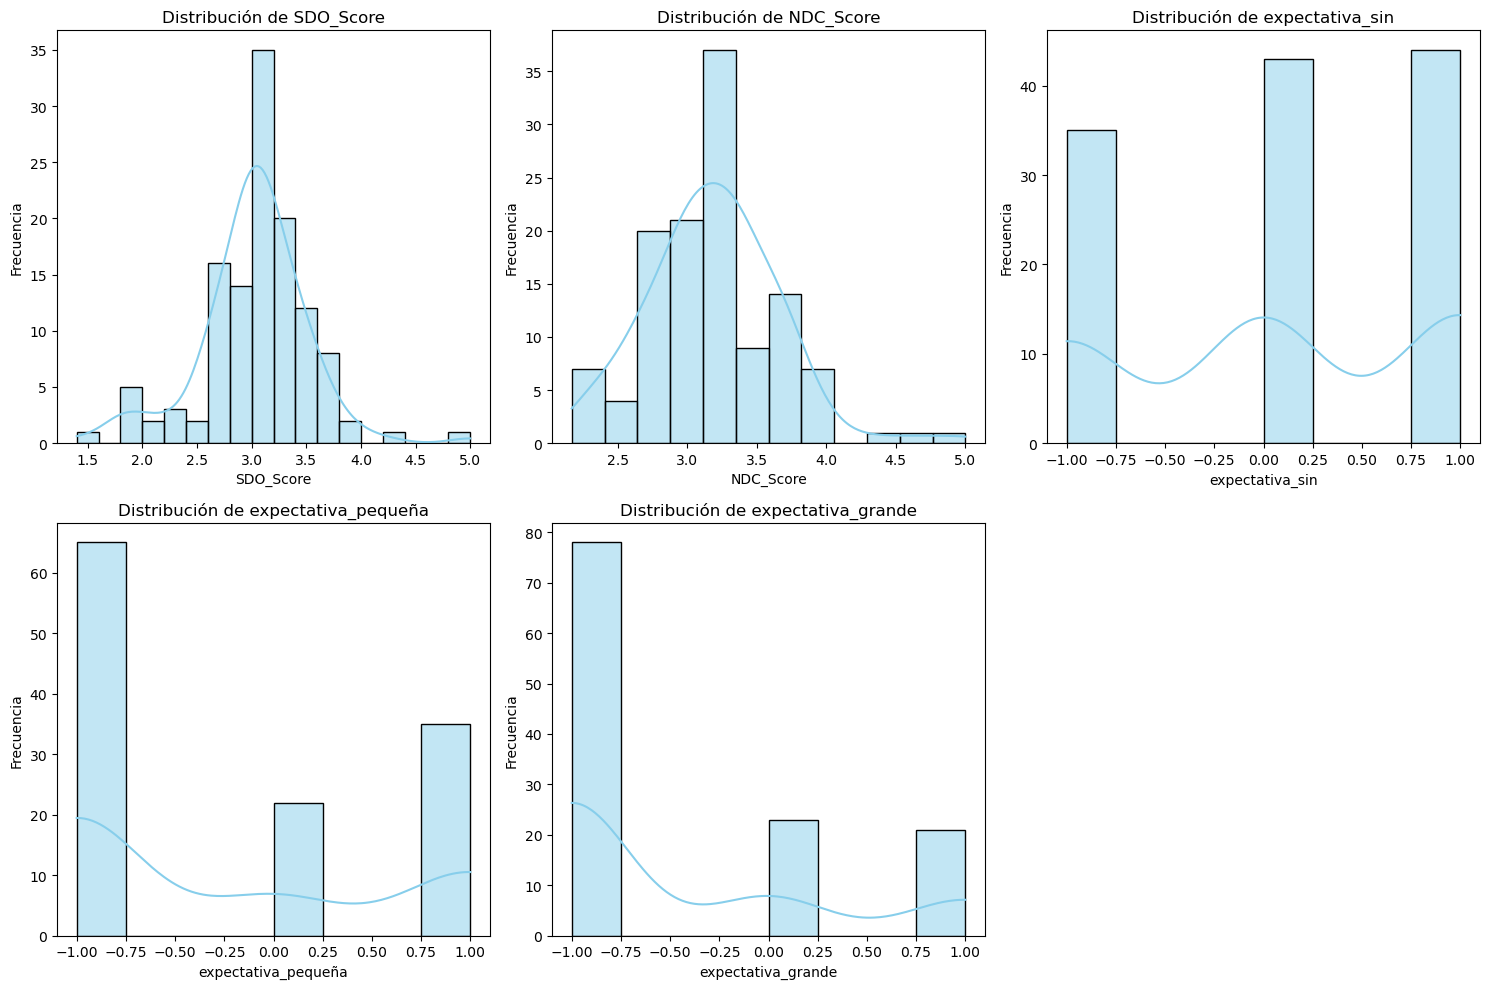

In [14]:
# ==============================================================================
# Distribución de Variables Clave (Histogramas)
# ==============================================================================

vars_clave = ['SDO_Score', 'NDC_Score', 'expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']

# Aumentamos la altura de la figura a 10 para acomodar 2 filas
plt.figure(figsize=(15, 10))

for i, var in enumerate(vars_clave):
    plt.subplot(2, 3, i+1)
    
    sns.histplot(df_dem_clean[var], kde=True, color='skyblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [15]:
# Definimos las listas separadas por tipo de variable
vars_categ = ['expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']
vars_num = ['SDO_Score', 'NDC_Score']

print("==========================================")
print(" TABLAS DE FRECUENCIA (Variables Categóricas)")
print("==========================================\n")

for var in vars_categ:
    if var in df_dem_clean.columns:
        print(f"--- Distribución de: {var} ---")
        # Calculamos frecuencia (n) y porcentaje (%)
        conteo = df_dem_clean[var].value_counts()
        porcentaje = df_dem_clean[var].value_counts(normalize=True) * 100
        
        # Unimos ambas en una tabla bonita
        tabla = pd.concat([conteo, porcentaje.round(1)], axis=1)
        tabla.columns = ['n', '%']
        print(tabla)
        print("-" * 30 + "\n")

print("\n==========================================")
print(" ESTADÍSTICOS DESCRIPTIVOS (Variables Numéricas)")
print("==========================================\n")

# Para SDO y NDC usamos describe() para obtener Media, Desviación, Mín y Máx
desc_stats = df_dem_clean[vars_num].describe().round(2)

# Seleccionamos solo las filas relevantes para el paper
filas_importantes = ['count', 'mean', 'std', 'min', 'max']
print(desc_stats.loc[filas_importantes])

 TABLAS DE FRECUENCIA (Variables Categóricas)

--- Distribución de: expectativa_sin ---
     n     %
 1  44  36.1
 0  43  35.2
-1  35  28.7
------------------------------

--- Distribución de: expectativa_pequeña ---
     n     %
-1  65  53.3
 1  35  28.7
 0  22  18.0
------------------------------

--- Distribución de: expectativa_grande ---
     n     %
-1  78  63.9
 0  23  18.9
 1  21  17.2
------------------------------


 ESTADÍSTICOS DESCRIPTIVOS (Variables Numéricas)

       SDO_Score  NDC_Score
count     122.00     122.00
mean        3.01       3.19
std         0.50       0.47
min         1.40       2.17
max         5.00       5.00


# --- 4. Pregunt4s b4sic4s ---
- ¿La condición afecta la decisión?
-     Distribución de respuest4 por tr4t4miento (dist, Bloque_CON, Bloque_SIN)
-     Test de Significancia (Chi-Cuadrado) y REGRESIÓN LOGÍSTICA (Para ver quién difiere de quién)
-     ANÁLISIS DE TRAYECTORIA INDIVIDUAL de condiciones
-          Disminuyó l4 reversión yendo de Dist/Blo#ue_Sin 4 Blo#ue_CON?
-          Disminuyó l4 reversión yendo de Blo#ue_CON 4 Dist/Blo#ue_Sin 4?
-          ANÁLISIS DE CONSISTENCIA INDIVIDUAL de condiciones

- ¿El t4m4ño del g4p moder4 l4 decision?
-     Distribución de respuest4 por t4m4ño de g4p
-     Distribución de respuest4 por blo#ue (Bloque_1, Bloque_3, Bloque_5, Bloque_7, Bloque_9, Bloque_11)
-     4n4lisis de consistenci4 individu4l de g4ps

- ¿Se 4line4 l4s decisiones con l4 expect4tiv4?
-     ANÁLISIS DE CONSISTENCIA: CREENCIAS VS. CONDUCTA (Solo Bloque_CON)


C:\Users\felip\AppData\Local\Temp\ipykernel_16176\2776083171.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_master, x='Dilema', y='Reversion', ci=95, palette="viridis", order=['Bloque_SIN', 'Bloque_CON', 'Dist'])


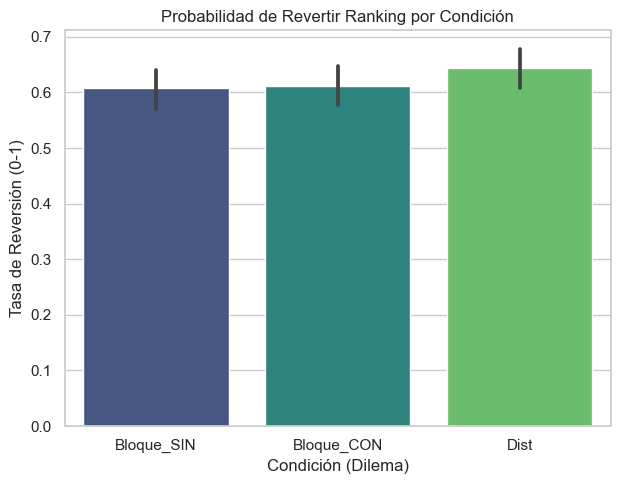


--- Tasas Medias de Reversión ---
Dilema
Bloque_CON    0.612022
Bloque_SIN    0.607923
Dist          0.643443
Name: Reversion, dtype: float64


In [22]:
# Configuración visual
sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))

#Tasa de Reversión por Tratamiento
plt.subplot(1, 2, 1)
sns.barplot(data=df_master, x='Dilema', y='Reversion', ci=95, palette="viridis", order=['Bloque_SIN', 'Bloque_CON', 'Dist'])
plt.title('Probabilidad de Revertir Ranking por Condición')
plt.ylabel('Tasa de Reversión (0-1)')
plt.xlabel('Condición (Dilema)')


plt.tight_layout()
plt.show() # O usar plt.savefig('resultados_descriptivos.png')

# Tabla resumen numérica
print("\n--- Tasas Medias de Reversión ---")
print(df_master.groupby('Dilema')['Reversion'].mean())

In [20]:
print("=== PRUEBA 1: TABLA DE CONTINGENCIA Y CHI-CUADRADO ===")
# 1. Creamos una tabla cruzada: Cantidad de Reversiones vs No Reversiones por Grupo
tabla_contingencia = pd.crosstab(df_master['Dilema'], df_master['Reversion'])
print(tabla_contingencia)

# 2. Ejecutamos el test
chi2, p_val, dof, expected = chi2_contingency(tabla_contingencia)

print(f"\nResultado Chi-Cuadrado:")
print(f"Estadístico Chi2: {chi2:.4f}")
print(f"P-Valor: {p_val:.5f}")

if p_val < 0.05:
    print(">> CONCLUSIÓN: SÍ hay diferencias significativas entre los grupos.")
    print("   (Al menos un grupo se comporta distinto a los otros).")
else:
    print(">> CONCLUSIÓN: NO hay diferencias significativas.")
    print("   (Las pequeñas variaciones del gráfico son puro azar).")


print("\n=== PRUEBA 2: REGRESIÓN LOGÍSTICA (Para ver quién difiere de quién) ===")
# Usamos regresión para comparar específicamente contra un grupo base
# Esto te da el detalle fino.
model_dilema = smf.logit("Reversion ~ C(Dilema)", data=df_master).fit()
print(model_dilema.summary())

=== PRUEBA 1: TABLA DE CONTINGENCIA Y CHI-CUADRADO ===
Reversion     0    1
Dilema              
Bloque_CON  284  448
Bloque_SIN  287  445
Dist        261  471

Resultado Chi-Cuadrado:
Estadístico Chi2: 2.3492
P-Valor: 0.30895
>> CONCLUSIÓN: NO hay diferencias significativas.
   (Las pequeñas variaciones del gráfico son puro azar).

=== PRUEBA 2: REGRESIÓN LOGÍSTICA (Para ver quién difiere de quién) ===
Optimization terminated successfully.
         Current function value: 0.662972
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Reversion   No. Observations:                 2196
Model:                          Logit   Df Residuals:                     2193
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:               0.0008094
Time:                        19:06:31   Log-Likelihood:                -1455.9
converged:       

In [28]:
import pandas as pd

print("=== ANÁLISIS DE TRAYECTORIA INDIVIDUAL ===")

# 1. CREAR MATRIZ DE CONDUCTA (PIVOT TABLE)
# Convertimos la tabla para que cada FILA sea un sujeto y cada COLUMNA una condición.
# Usamos 'round' para binarizar: Si su promedio de reversión fue > 0.5, ponemos 1 (Revirtió).
# Si fue < 0.5, ponemos 0 (No Revirtió).
matriz_conducta = df_master.pivot_table(
    index='ID_Sujeto', 
    columns='Dilema', 
    values='Reversion', 
    aggfunc='mean'
).round()

print(f"Total de sujetos analizados: {len(matriz_conducta)}")
print("Muestra de la matriz (0 = No Revierte, 1 = Revierte):")
print(matriz_conducta.head())

# 2. FILTRAR EL PERFIL ESPECÍFICO
# Buscamos: (Dist == 1) Y (Bloque_SIN == 1) Y (Bloque_CON == 0)

# Verificamos primero que existan las columnas para evitar errores
cols_necesarias = ['Dist', 'Bloque_SIN', 'Bloque_CON']
if all(col in matriz_conducta.columns for col in cols_necesarias):
    
    # Aplicamos el filtro lógico
    sujetos_sensibles = matriz_conducta[
        (matriz_conducta['Dist'] == 1) & 
        (matriz_conducta['Bloque_SIN'] == 1) & 
        (matriz_conducta['Bloque_CON'] == 0)
    ]
    
    n_sensibles = len(sujetos_sensibles)
    total = len(matriz_conducta)
    pct = (n_sensibles / total) * 100
    
    print("\n" + "="*40)
    print(f"RESULTADO: {n_sensibles} personas cumplen el criterio.")
    print(f"Representan el {pct:.2f}% de la muestra.")
    print("="*40)
    
    if n_sensibles > 0:
        print("\nIDs de estos sujetos (para inspección cualitativa):")
        print(sujetos_sensibles.index.tolist())
        
        # Opcional: Ver sus medias exactas (no redondeadas) para ver si dudaron
        print("\nSus puntajes reales (Promedios):")
        raw_pivot = df_master.pivot_table(index='ID_Sujeto', columns='Dilema', values='Reversion')
        print(raw_pivot.loc[sujetos_sensibles.index])
else:
    print("\nERROR: No se encontraron las 3 condiciones en la columna 'Dilema'.")
    print("Columnas encontradas:", matriz_conducta.columns.tolist())

=== ANÁLISIS DE TRAYECTORIA INDIVIDUAL ===
Total de sujetos analizados: 121
Muestra de la matriz (0 = No Revierte, 1 = Revierte):
Dilema     Bloque_CON  Bloque_SIN  Dist
ID_Sujeto                              
Suj_001           1.0         0.0   0.0
Suj_003           1.0         1.0   1.0
Suj_004           1.0         1.0   1.0
Suj_006           0.0         0.0   1.0
Suj_007           0.0         0.0   0.0

RESULTADO: 9 personas cumplen el criterio.
Representan el 7.44% de la muestra.

IDs de estos sujetos (para inspección cualitativa):
['Suj_011', 'Suj_015', 'Suj_038', 'Suj_073', 'Suj_088', 'Suj_091', 'Suj_130', 'Suj_141', 'Suj_147']

Sus puntajes reales (Promedios):
Dilema     Bloque_CON  Bloque_SIN      Dist
ID_Sujeto                                  
Suj_011      0.333333    0.666667  0.666667
Suj_015      0.500000    0.666667  0.666667
Suj_038      0.333333    0.833333  1.000000
Suj_073      0.500000    0.666667  0.666667
Suj_088      0.500000    0.833333  0.666667
Suj_091      0.

In [29]:
import pandas as pd

print("=== ANÁLISIS INVERSO: Perfil Reactivo ===")
print("Buscando sujetos que revierten SOLO en Bloque_CON (y no en los otros)...")

# 1. Aseguramos que la matriz existe (si ya corriste el anterior, esto es redundante pero seguro)
matriz_conducta = df_master.pivot_table(
    index='ID_Sujeto', 
    columns='Dilema', 
    values='Reversion', 
    aggfunc='mean'
).round()

# 2. FILTRAR EL PERFIL "REACTIVO"
# Lógica: (Bloque_CON == 1) Y (Dist == 0) Y (Bloque_SIN == 0)
cols_necesarias = ['Dist', 'Bloque_SIN', 'Bloque_CON']

if all(col in matriz_conducta.columns for col in cols_necesarias):
    
    sujetos_reactivos = matriz_conducta[
        (matriz_conducta['Bloque_CON'] == 1) & 
        (matriz_conducta['Dist'] == 0) & 
        (matriz_conducta['Bloque_SIN'] == 0)
    ]
    
    n_reactivos = len(sujetos_reactivos)
    total = len(matriz_conducta)
    pct = (n_reactivos / total) * 100
    
    print("\n" + "="*40)
    print(f"RESULTADO: {n_reactivos} personas cumplen este perfil inverso.")
    print(f"Representan el {pct:.2f}% de la muestra.")
    print("="*40)
    
    if n_reactivos > 0:
        print("\nIDs de estos sujetos:")
        print(sujetos_reactivos.index.tolist())
        
        # Ver sus datos crudos para confirmar
        print("\nSus puntajes reales:")
        print(df_master.pivot_table(index='ID_Sujeto', columns='Dilema', values='Reversion').loc[sujetos_reactivos.index])
    else:
        print("\nNadie mostró este comportamiento específico.")

else:
    print("Error: Faltan columnas en la matriz.")

=== ANÁLISIS INVERSO: Perfil Reactivo ===
Buscando sujetos que revierten SOLO en Bloque_CON (y no en los otros)...

RESULTADO: 6 personas cumplen este perfil inverso.
Representan el 4.96% de la muestra.

IDs de estos sujetos:
['Suj_001', 'Suj_022', 'Suj_035', 'Suj_090', 'Suj_110', 'Suj_135']

Sus puntajes reales:
Dilema     Bloque_CON  Bloque_SIN      Dist
ID_Sujeto                                  
Suj_001      0.833333    0.333333  0.333333
Suj_022      1.000000    0.500000  0.500000
Suj_035      0.833333    0.500000  0.333333
Suj_090      0.833333    0.333333  0.333333
Suj_110      0.833333    0.500000  0.500000
Suj_135      0.666667    0.333333  0.500000


=== ANÁLISIS DE CONSISTENCIA INDIVIDUAL ===

--- A. Resumen General ---
Total Sujetos Analizados: 121
Sujetos Consistentes (Siempre igual): 76 (62.8%)
Sujetos Cambiantes (Afectados por condición): 45 (37.2%)

--- B. Patrones de Comportamiento (SIN - CON - DIST) ---
  Patron (SIN-CON-DIST)  Cantidad     %
0                 1-1-1        52  43.0
1                 0-0-0        24  19.8
2                 0-0-1        12   9.9
3                 1-0-1         9   7.4
4                 0-1-1         9   7.4
5                 1-1-0         7   5.8
6                 0-1-0         6   5.0
7                 1-0-0         2   1.7


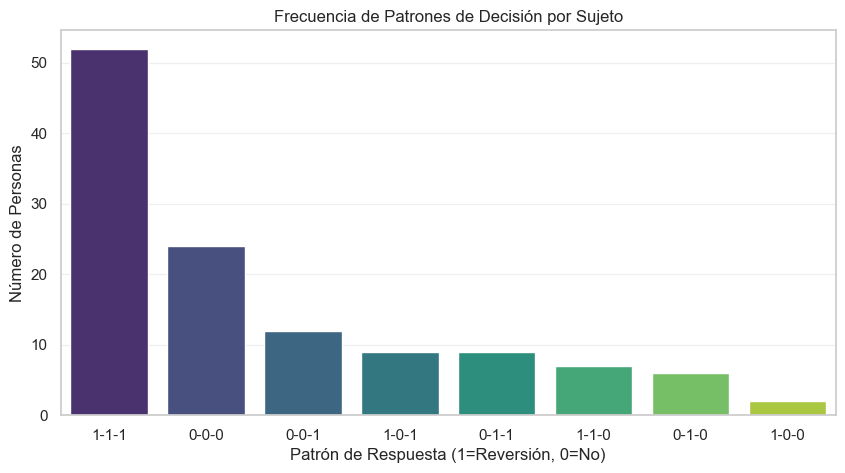

In [30]:
print("=== ANÁLISIS DE CONSISTENCIA INDIVIDUAL ===")

# 1. PREPARAR MATRIZ (Sujetos x Condiciones)
# Binarizamos la decisión (0 o 1) redondeando el promedio
matriz = df_master.pivot_table(
    index='ID_Sujeto', 
    columns='Dilema', 
    values='Reversion', 
    aggfunc='mean'
).round()

# Filtramos solo a quienes tienen datos en las 3 condiciones (para ser justos)
cols_cond = ['Bloque_SIN', 'Bloque_CON', 'Dist']
if all(c in matriz.columns for c in cols_cond):
    matriz = matriz.dropna(subset=cols_cond) # Elimina sujetos incompletos
    
    # 2. DEFINIR CONSISTENCIA
    # Si la desviación estándar es 0, es que todos sus valores fueron iguales (0-0-0 o 1-1-1)
    matriz['Es_Consistente'] = matriz[cols_cond].std(axis=1) == 0
    
    # 3. CREAR EL "PATRÓN" (Etiqueta de texto para agrupar)
    # Ejemplo: "1-1-0" significa Revirtió en SIN, Revirtió en CON, No en Dist.
    def hacer_patron(row):
        return f"{int(row['Bloque_SIN'])}-{int(row['Bloque_CON'])}-{int(row['Dist'])}"
    
    matriz['Patron'] = matriz.apply(hacer_patron, axis=1)

    # ==========================================
    # RESULTADOS
    # ==========================================
    
    # A) ¿Cuántos cambiaron? (Tasa de "Switching")
    conteo_consistencia = matriz['Es_Consistente'].value_counts()
    pct_consistencia = matriz['Es_Consistente'].value_counts(normalize=True) * 100
    
    print("\n--- A. Resumen General ---")
    print(f"Total Sujetos Analizados: {len(matriz)}")
    print(f"Sujetos Consistentes (Siempre igual): {conteo_consistencia.get(True, 0)} ({pct_consistencia.get(True, 0):.1f}%)")
    print(f"Sujetos Cambiantes (Afectados por condición): {conteo_consistencia.get(False, 0)} ({pct_consistencia.get(False, 0):.1f}%)")
    
    # B) Detalle de los Patrones (¿Qué cambios fueron más comunes?)
    print("\n--- B. Patrones de Comportamiento (SIN - CON - DIST) ---")
    patrones = matriz['Patron'].value_counts().reset_index()
    patrones.columns = ['Patron (SIN-CON-DIST)', 'Cantidad']
    patrones['%'] = (patrones['Cantidad'] / len(matriz) * 100).round(1)
    
    # Interpretación automática de los patrones top
    print(patrones)
    
    # 4. VISUALIZACIÓN
    plt.figure(figsize=(10, 5))
    sns.barplot(data=patrones, x='Patron (SIN-CON-DIST)', y='Cantidad', palette='viridis')
    plt.title('Frecuencia de Patrones de Decisión por Sujeto')
    plt.ylabel('Número de Personas')
    plt.xlabel('Patrón de Respuesta (1=Reversión, 0=No)')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

else:
    print("Error: No se encontraron las columnas de condición necesarias:", cols_cond)

=== ANÁLISIS 1: ¿EL TAMAÑO DEL GAP MODERA LA DECISIÓN? ===

>>> Tabla 1: Porcentaje de Reversión según Tamaño del Gap
            mean  count       std
Nivel_Gap                        
1_Nulo     38.25    732  0.486333
2_Bajo     68.44    732  0.465062
3_Alto     79.64    732  0.402915


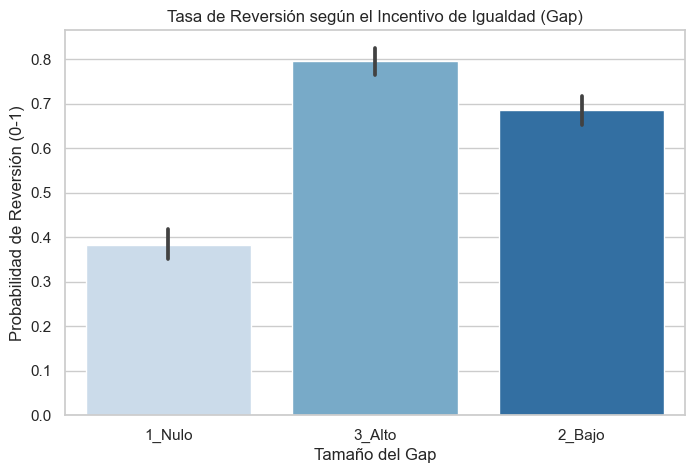


=== ANÁLISIS 2: DISTRIBUCIÓN POR BLOQUE ESPECÍFICO ===

>>> Tabla 2: Porcentaje de Reversión por Bloque
            mean  count
Bloque                 
Bloque_1   34.97    366
Bloque_3   41.53    366
Bloque_9   66.67    366
Bloque_11  70.22    366
Bloque_5   77.05    366
Bloque_7   82.24    366


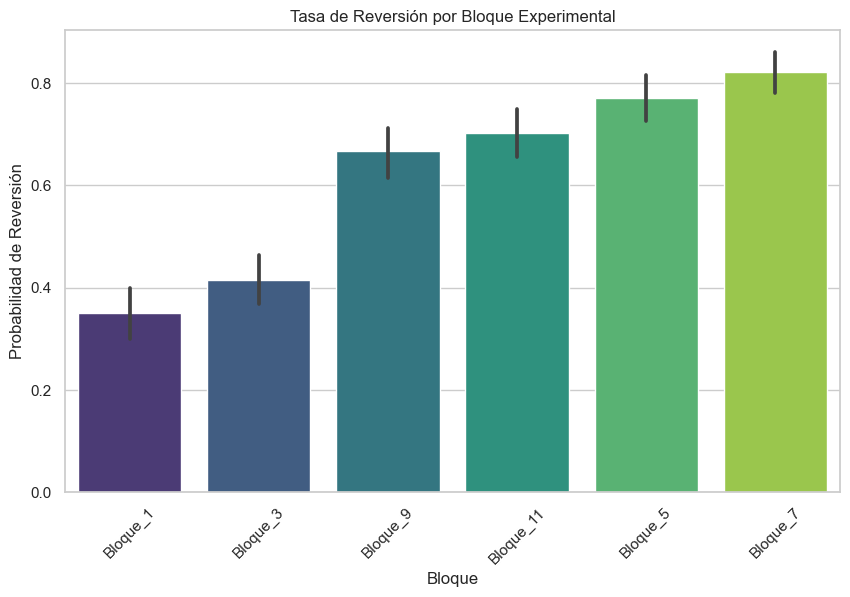

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("=== ANÁLISIS 1: ¿EL TAMAÑO DEL GAP MODERA LA DECISIÓN? ===")

# 1. Recreamos la variable Nivel_Gap por seguridad (Nulo -> Bajo -> Alto)
def clasificar_gap(row):
    b = row.get('Bloque', '')
    if b in ["Bloque_1", "Bloque_3"]: return "1_Nulo"
    if b in ["Bloque_9", "Bloque_11"]: return "2_Bajo"
    if b in ["Bloque_5", "Bloque_7"]: return "3_Alto"
    return "Otro"

if 'Bloque' in df_master.columns:
    df_master['Nivel_Gap'] = df_master.apply(clasificar_gap, axis=1)

    # --- A. Distribución por Tamaño del Gap ---
    # Calculamos Tasa de Reversión (Media) y Cantidad de Casos (Count)
    tabla_gap = df_master.groupby('Nivel_Gap')['Reversion'].agg(['mean', 'count', 'std'])
    tabla_gap['mean'] = (tabla_gap['mean'] * 100).round(2) # Convertir a %
    
    print("\n>>> Tabla 1: Porcentaje de Reversión según Tamaño del Gap")
    print(tabla_gap)

    # Gráfico 1
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Nivel_Gap', y='Reversion', data=df_master, palette="Blues", errorbar=('ci', 95))
    plt.title("Tasa de Reversión según el Incentivo de Igualdad (Gap)")
    plt.ylabel("Probabilidad de Reversión (0-1)")
    plt.xlabel("Tamaño del Gap")
    plt.show()

    
    print("\n=== ANÁLISIS 2: DISTRIBUCIÓN POR BLOQUE ESPECÍFICO ===")
    
    # --- B. Distribución por Bloque (Desglose fino) ---
    # Ordenamos los bloques para que salgan lógicos en el gráfico (1, 3, 5...)
    orden_bloques = ["Bloque_1", "Bloque_3", "Bloque_9", "Bloque_11", "Bloque_5", "Bloque_7"]
    
    # Filtramos solo los bloques que existen en los datos
    bloques_reales = [b for b in orden_bloques if b in df_master['Bloque'].unique()]
    
    tabla_bloque = df_master.groupby('Bloque')['Reversion'].agg(['mean', 'count'])
    tabla_bloque['mean'] = (tabla_bloque['mean'] * 100).round(2)
    
    # Reordenamos la tabla según el orden lógico
    tabla_bloque = tabla_bloque.reindex(bloques_reales)
    
    print("\n>>> Tabla 2: Porcentaje de Reversión por Bloque")
    print(tabla_bloque)

    # Gráfico 2
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Bloque', 
        y='Reversion', 
        data=df_master, 
        order=bloques_reales, # Forzamos el orden visual
        palette="viridis",
        errorbar=('ci', 95)
    )
    plt.title("Tasa de Reversión por Bloque Experimental")
    plt.ylabel("Probabilidad de Reversión")
    plt.xticks(rotation=45)
    plt.show()

else:
    print("Error: No se encuentra la columna 'Bloque'.")

C:\Users\felip\AppData\Local\Temp\ipykernel_16176\2761069224.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_master, x='Gap_Size', y='Reversion', hue='Dilema', ci=None, marker='o')


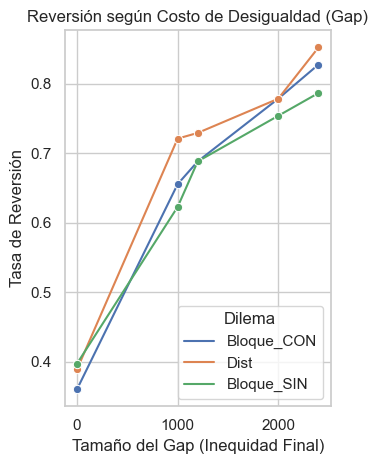

 TABLA 2: Efecto del Costo (Gap) en la Reversión

--- Probabilidad Promedio de Reversión ---
Dilema    Bloque_CON  Bloque_SIN  Dist
Gap_Size                              
0               0.36        0.40  0.39
1000            0.66        0.62  0.72
1200            0.69        0.69  0.73
2000            0.78        0.75  0.78
2400            0.83        0.79  0.85


--- Detalle Estadístico (Promedio y Cantidad de Casos) ---
                     mean  count   std
Dilema     Gap_Size                   
Bloque_CON 0         0.36    244  0.48
           1000      0.66    122  0.48
           1200      0.69    122  0.47
           2000      0.78    122  0.42
           2400      0.83    122  0.38
Bloque_SIN 0         0.40    244  0.49
           1000      0.62    122  0.49
           1200      0.69    122  0.47
           2000      0.75    122  0.43
           2400      0.79    122  0.41
Dist       0         0.39    244  0.49
           1000      0.72    122  0.45
           1200      0.73  

In [26]:
# Gráfico 2: Efecto del Gap 
# 
plt.subplot(1, 2, 2)
sns.lineplot(data=df_master, x='Gap_Size', y='Reversion', hue='Dilema', ci=None, marker='o')
plt.title('Reversión según Costo de Desigualdad (Gap)')
plt.ylabel('Tasa de Reversión')
plt.xlabel('Tamaño del Gap (Inequidad Final)')

plt.tight_layout()
plt.show()

print("==========================================")
print(" TABLA 2: Efecto del Gap en la Reversión")
print("==========================================\n")

# 1. TABLA PIVOTE (La versión limpia para leer)
# Muestra el promedio de reversión (0 a 1) cruando Gap vs Dilema
tabla_gap = df_master.pivot_table(
    index='Gap_Size', 
    columns='Dilema', 
    values='Reversion', 
    aggfunc='mean'
)

print("--- Probabilidad Promedio de Reversión ---")
# Multiplicamos por 100 si prefieres porcentajes, o lo dejamos así (0-1)
print(tabla_gap.round(2))


# 2. VALIDACIÓN DE MUESTRA (Importante para el Paper)
# Es vital saber si en los Gaps muy altos (ej. 2400) hay la misma cantidad
# de gente que en los bajos. Si 'count' baja mucho, el dato es menos confiable.
print("\n\n--- Detalle Estadístico (Promedio y Cantidad de Casos) ---")
stats_gap = df_master.groupby(['Dilema', 'Gap_Size'])['Reversion'].agg(['mean', 'count', 'std'])

print(stats_gap.round(2))

=== FRECUENCIA DE PATRONES (Ordenados por Popularidad) ===

--- Patrones más comunes (De mayor a menor) ---
  Patron (Nulo-Bajo-Alto)  Cantidad     %
0                   0-1-1        54  44.6
1                   1-1-1        24  19.8
2                   0-0-0        17  14.0
3                   0-0-1        15  12.4
4                   Otros         6   5.0
5                   1-1-0         3   2.5
6                   1-0-0         2   1.7


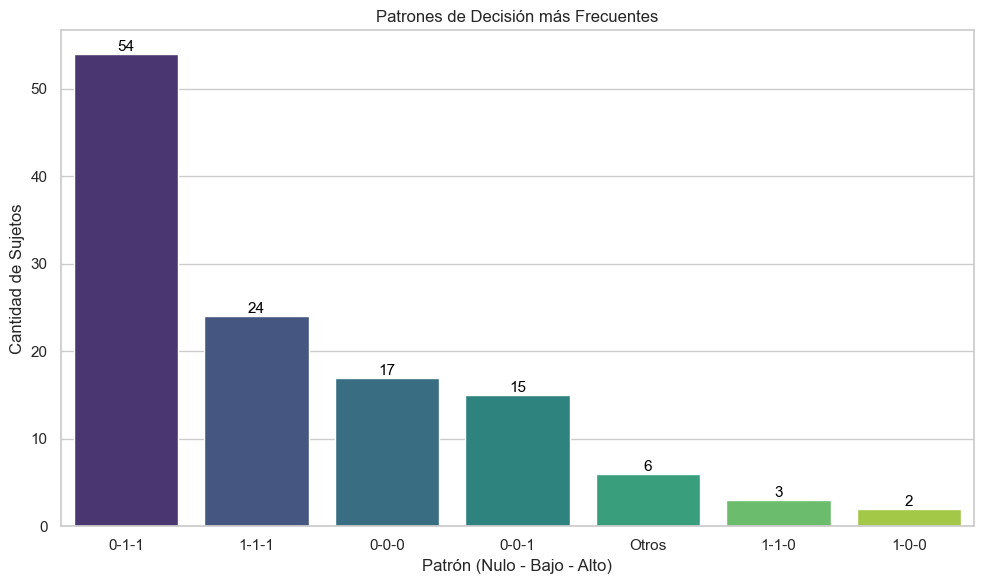

In [34]:
print("=== consistenci4/sensibilid4d 4l g4p intr4 sujeto ===")

# 1. CLASIFICAR EL GAP (Orden: Nulo -> Bajo -> Alto)
def clasificar_gap_ordenado(row):
    b = row.get('Bloque', '')
    if b in ["Bloque_1", "Bloque_3"]: return "1_Nulo"
    if b in ["Bloque_9", "Bloque_11"]: return "2_Bajo"
    if b in ["Bloque_5", "Bloque_7"]: return "3_Alto"
    return None

if 'Bloque' in df_master.columns:
    df_master['Nivel_Gap'] = df_master.apply(clasificar_gap_ordenado, axis=1)
    
    # 2. CREAR MATRIZ
    matriz_gap = df_master.pivot_table(
        index='ID_Sujeto', 
        columns='Nivel_Gap', 
        values='Reversion', 
        aggfunc='mean'
    ).round()

    # Filtramos columnas y nulos
    cols_ordenadas = ["1_Nulo", "2_Bajo", "3_Alto"]
    cols_reales = [c for c in cols_ordenadas if c in matriz_gap.columns]
    matriz_gap = matriz_gap[cols_reales].dropna()

    # 3. CREAR ETIQUETA DE PATRÓN ("0-0-0", "1-1-1", etc.)
    matriz_gap['Patron'] = matriz_gap.apply(
        lambda x: "-".join([str(int(x[col])) for col in cols_reales]), axis=1
    )
    
    # 4. AGRUPAR "OTROS" (Opcional, para limpiar ruido visual)
    def simplificar_etiqueta(patron):
        # Mantenemos los perfiles teóricamente relevantes
        principales = ["0-0-0", "1-1-1", "0-0-1", "0-1-1", "1-0-0", "1-1-0"]
        if patron in principales:
            return patron
        else:
            return "Otros"

    matriz_gap['Etiqueta_Grafico'] = matriz_gap['Patron'].apply(simplificar_etiqueta)

    # ==========================================
    # 5. ORDENAMIENTO POR FRECUENCIA (El cambio clave)
    # ==========================================
    # Calculamos el orden exacto de mayor a menor
    orden_frecuencia = matriz_gap['Etiqueta_Grafico'].value_counts().index

    # Tabla para ver los números exactos
    conteo = matriz_gap['Etiqueta_Grafico'].value_counts().reset_index()
    conteo.columns = ['Patron (Nulo-Bajo-Alto)', 'Cantidad']
    conteo['%'] = (conteo['Cantidad'] / len(matriz_gap) * 100).round(1)
    
    print("\n--- Patrones más comunes (De mayor a menor) ---")
    print(conteo)

    # ==========================================
    # 6. GRÁFICO
    # ==========================================
    plt.figure(figsize=(10, 6))
    
    sns.countplot(
        data=matriz_gap, 
        x='Etiqueta_Grafico', 
        order=orden_frecuencia, # ¡Aquí aplicamos el orden dinámico!
        palette='viridis'
    )
    
    plt.title('Patrones de Decisión más Frecuentes')
    plt.xlabel('Patrón (Nulo - Bajo - Alto)')
    plt.ylabel('Cantidad de Sujetos')
    
    # Agregamos los números sobre las barras para mayor claridad
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

else:
    print("Error: Falta columna Bloque.")

In [38]:
 df_master.columns.tolist()

['ID_Sujeto',
 'Origen_Form',
 'Identidad',
 'Bloque',
 'Dilema',
 'Categoria',
 'Respuesta',
 'Reversion',
 'SDO_Score',
 'NDC_Score',
 'expectativa_sin',
 'expectativa_grande',
 'expectativa_pequeña',
 'Gap_Size',
 'expectativa_sin_num',
 'expectativa_grande_num',
 'expectativa_pequeña_num',
 'Expectativa_Activa',
 'Nivel_Gap']

=== ANÁLISIS DE CONTROLES DEMOGRÁFICOS ===

>>> 1. Efecto de Variables Categóricas (Chi-Cuadrado)

--- Análisis de: Genero ---
            % Reversión     N
Genero                       
Hombre            63.45   684
Mujer             61.04  1458
No binario        77.78    36
Otro              66.67    18
Resultado Chi2: p-valor = 0.1617
(ok) No hay diferencias significativas según Genero.


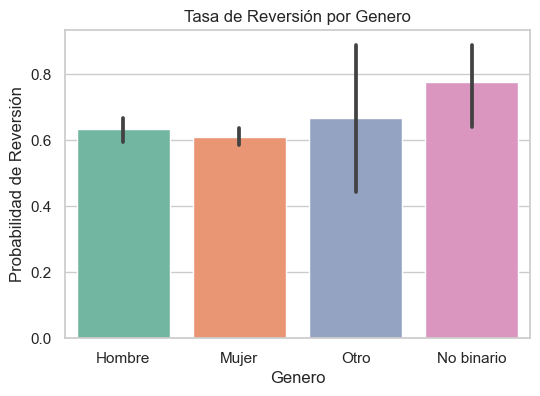


--- Análisis de: nivel_se ---
          % Reversión    N
nivel_se                  
2               61.11   36
3               63.89  144
4               66.08  342
5               65.33  522
6               63.64  594
7               53.33  360
8               53.47  144
9               80.56   36
10              38.89   18
Resultado Chi2: p-valor = 0.0001
(!) Hay diferencias significativas en la decisión según nivel_se.


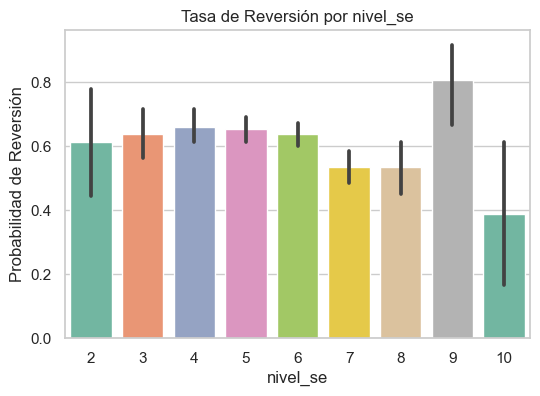


--- Análisis de: politica ---
          % Reversión    N
politica                  
1               63.49  126
2               68.78  378
3               60.58  378
4               60.19  756
5               55.26  342
6               70.99  162
7               66.67   54
Resultado Chi2: p-valor = 0.0015
(!) Hay diferencias significativas en la decisión según politica.


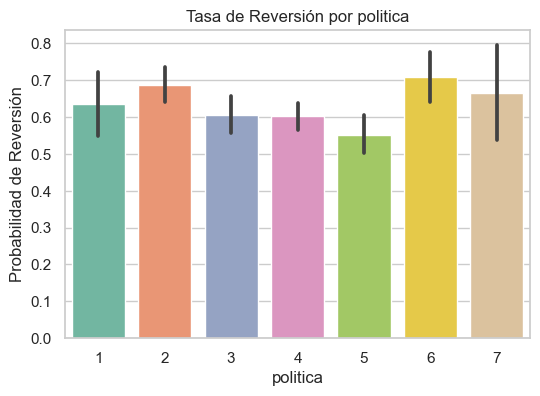


>>> 2. Efecto de Variables Psicométricas (Regresión Logística)

--- Modelo Logístico: Reversion ~ SDO_Score ---
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2921      0.272     -1.074      0.283      -0.825       0.241
SDO_Score      0.2618      0.090      2.922      0.003       0.086       0.437
(!) Significativo: A mayor SDO_Score, AUMENTA la probabilidad de revertir.


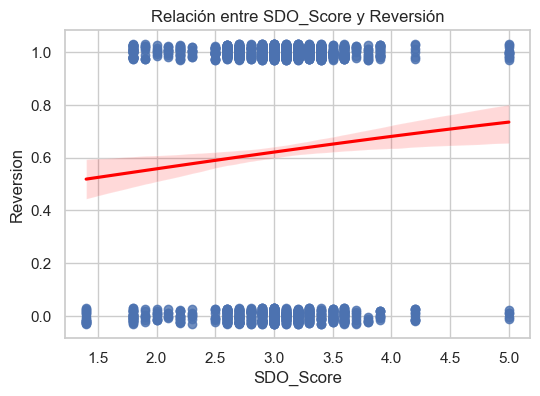


--- Modelo Logístico: Reversion ~ NDC_Score ---
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3816      0.300      1.272      0.203      -0.206       0.970
NDC_Score      0.0354      0.093      0.380      0.704      -0.147       0.218
(ok) NDC_Score NO predice significativamente la decisión.


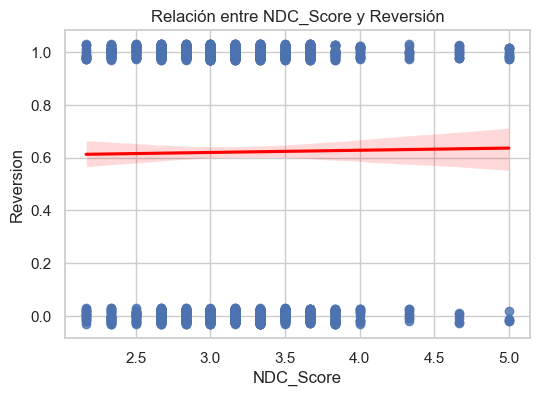


>>> 3. Modelo Demográfico Completo (Controlando todo junto)
Optimization terminated successfully.
         Current function value: 0.657801
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Reversion   No. Observations:                 2196
Model:                          Logit   Df Residuals:                     2188
Method:                           MLE   Df Model:                            7
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:                0.008602
Time:                        21:08:42   Log-Likelihood:                -1444.5
converged:                       True   LL-Null:                       -1457.1
Covariance Type:            nonrobust   LLR p-value:                 0.0007385
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.

In [40]:
print("=== ANÁLISIS DE CONTROLES DEMOGRÁFICOS ===")

# Lista de variables categóricas a analizar
vars_categ = ['Genero', 'nivel_se', 'politica']
# Lista de variables continuas (Escalas)
vars_cont = ['SDO_Score', 'NDC_Score']

# ==============================================================================
# PARTE 1: Variables Categóricas (Género, NSE, Política)
# ==============================================================================
print("\n>>> 1. Efecto de Variables Categóricas (Chi-Cuadrado)")

for var in vars_categ:
    if var in df_master.columns:
        print(f"\n--- Análisis de: {var} ---")
        
        # A. Tabla de Porcentajes de Reversión
        tabla = df_master.groupby(var)['Reversion'].agg(['mean', 'count'])
        tabla['mean'] = (tabla['mean'] * 100).round(2)
        tabla.columns = ['% Reversión', 'N']
        print(tabla)
        
        # B. Test Estadístico (Chi-Cuadrado)
        # Creamos tabla cruzada (Crosstab)
        contingencia = pd.crosstab(df_master[var], df_master['Reversion'])
        chi2, p, dof, ex = chi2_contingency(contingencia)
        
        print(f"Resultado Chi2: p-valor = {p:.4f}")
        if p < 0.05:
            print(f"(!) Hay diferencias significativas en la decisión según {var}.")
        else:
            print(f"(ok) No hay diferencias significativas según {var}.")
            
        # C. Gráfico
        plt.figure(figsize=(6, 4))
        sns.barplot(x=var, y='Reversion', data=df_master, palette="Set2", errorbar=('ci', 95))
        plt.title(f'Tasa de Reversión por {var}')
        plt.ylabel('Probabilidad de Reversión')
        plt.show()
    else:
        print(f"Variable '{var}' no encontrada.")

# ==============================================================================
# PARTE 2: Variables Continuas (SDO y NDC)
# ==============================================================================
print("\n>>> 2. Efecto de Variables Psicométricas (Regresión Logística)")

for var in vars_cont:
    if var in df_master.columns:
        print(f"\n--- Modelo Logístico: Reversion ~ {var} ---")
        
        # Ajustamos regresión logística simple
        formula = f"Reversion ~ {var}"
        model = smf.logit(formula, data=df_master).fit(disp=0)
        
        # Extraemos p-valor y coeficiente
        p_val = model.pvalues[var]
        coef = model.params[var]
        
        print(model.summary().tables[1])
        
        if p_val < 0.05:
            direccion = "AUMENTA" if coef > 0 else "DISMINUYE"
            print(f"(!) Significativo: A mayor {var}, {direccion} la probabilidad de revertir.")
        else:
            print(f"(ok) {var} NO predice significativamente la decisión.")
            
        # Gráfico de Tendencia
        plt.figure(figsize=(6, 4))
        sns.regplot(x=var, y='Reversion', data=df_master, logistic=True, 
                    y_jitter=0.03, line_kws={'color': 'red'})
        plt.title(f'Relación entre {var} y Reversión')
        plt.show()

# ==============================================================================
# PARTE 3: MODELO MULTIVARIADO (La prueba de fuego)
# ==============================================================================
print("\n>>> 3. Modelo Demográfico Completo (Controlando todo junto)")
# ¿Qué pasa si metemos todo en la licuadora?
# Esto te dice si el Género importa "de verdad" o si era solo porque tenían distinto SDO.

# Construimos la fórmula dinámicamente con las variables que existan
all_vars = [v for v in vars_categ + vars_cont if v in df_master.columns]
formula_full = "Reversion ~ " + " + ".join(all_vars)

try:
    model_full = smf.logit(formula_full, data=df_master).fit()
    print(model_full.summary())
except Exception as e:
    print(f"No se pudo ajustar el modelo completo: {e}")

=== ANÁLISIS DE CONSISTENCIA: CREENCIAS VS. CONDUCTA (Solo Bloque_CON) ===


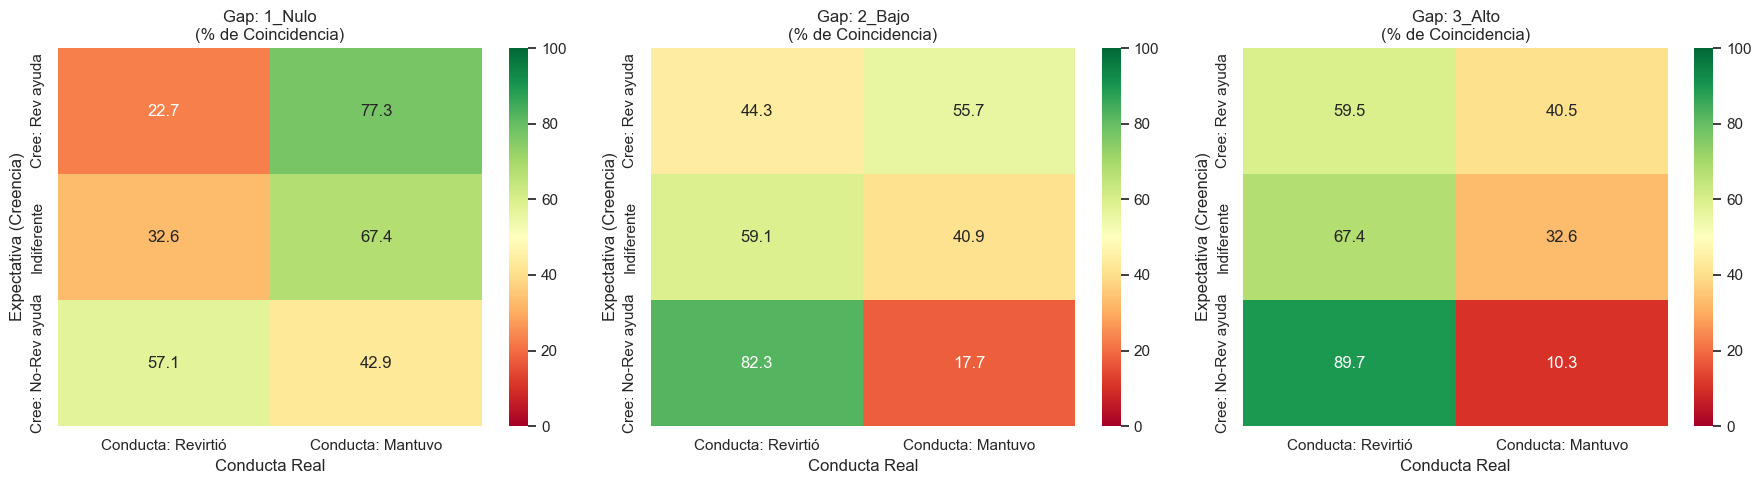


--- Resumen de Coherencia por Gap ---
Check_Coherencia  Coherente (Conservador)  Coherente (Pro-Cambio)  \
Nivel_Gap                                                           
1_Nulo                               12.3                     8.2   
2_Bajo                                9.4                    12.7   
3_Alto                                6.6                    10.2   

Check_Coherencia  Incoherente (Disonancia)  Neutro  
Nivel_Gap                                           
1_Nulo                                44.3    35.2  
2_Bajo                                59.8    18.0  
3_Alto                                64.3    18.9  


In [53]:
print("=== ANÁLISIS DE CONSISTENCIA: CREENCIAS VS. CONDUCTA (Solo Bloque_CON) ===")

# 1. FILTRAR DATOS
# Solo nos interesa cuando la condición está presente (Bloque_CON)
# Asumimos que la columna se llama 'Dilema' o 'Condicion'. Ajusta si es necesario.
# Si tu columna es 'Dilema', usa esta línea:
df_con = df_master[df_master['Dilema'] == 'Bloque_CON'].copy()

# 2. ASEGURAR CLASIFICACIÓN DE GAP
def clasificar_gap(row):
    b = row.get('Bloque', '')
    if b in ["Bloque_1", "Bloque_3"]: return "1_Nulo"
    if b in ["Bloque_9", "Bloque_11"]: return "2_Bajo"
    if b in ["Bloque_5", "Bloque_7"]: return "3_Alto"
    return None

df_con['Nivel_Gap'] = df_con.apply(clasificar_gap, axis=1)

# 3. ETIQUETAS PARA LEER MEJOR LOS GRÁFICOS
# Mapeamos los números (-1, 0, 1) a texto claro
mapa_creencia = {
    1.0: "Cree: Rev ayuda",   # Opción 1 (Revertir) ayuda a cooperar
    0.0: "Indiferente",
   -1.0: "Cree: No-Rev ayuda" # Opción 2 (Mantener) ayuda a cooperar
}
mapa_conducta = {
    1: "Conducta: Revirtió",
    0: "Conducta: Mantuvo"
}

df_con['Creencia_Txt'] = df_con['Expectativa_Activa'].map(mapa_creencia)
df_con['Conducta_Txt'] = df_con['Reversion'].map(mapa_conducta)

# 4. GENERAR MATRICES POR CADA NIVEL DE GAP
gaps = ["1_Nulo", "2_Bajo", "3_Alto"]

plt.figure(figsize=(18, 5))

for i, gap in enumerate(gaps):
    # Filtramos por Gap
    data_gap = df_con[df_con['Nivel_Gap'] == gap]
    
    if len(data_gap) > 0:
        # Creamos Tabla Cruzada (Crosstab)
        matriz = pd.crosstab(
            data_gap['Creencia_Txt'], 
            data_gap['Conducta_Txt'], 
            normalize='index' # Para ver % dentro de cada creencia
        ) * 100
        
        # Ordenamos las filas para que sea lógico (-1, 0, 1)
        orden_filas = ["Cree: Rev ayuda", "Indiferente", "Cree: No-Rev ayuda"]
        orden_cols = ["Conducta: Revirtió", "Conducta: Mantuvo"]
        
        # Filtramos solo las que existen para no dar error
        filas_reales = [f for f in orden_filas if f in matriz.index]
        cols_reales = [c for c in orden_cols if c in matriz.columns]
        matriz = matriz.loc[filas_reales, cols_reales]

        # Visualización (Heatmap)
        plt.subplot(1, 3, i+1)
        sns.heatmap(matriz, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100)
        plt.title(f"Gap: {gap}\n(% de Coincidencia)")
        plt.ylabel("Expectativa (Creencia)")
        plt.xlabel("Conducta Real")
    
plt.tight_layout()
plt.show()

# 5. ESTADÍSTICA DE COHERENCIA GLOBAL
# Calculamos un score simple: ¿Coincidió el signo?
# (1 con 1) o (-1 con 0/Mantener) -> Ojo, aqui 'Mantener' es 0 en conducta pero -1 en expectativa idealmente.
# Vamos a definir "Coherente" si:
# - Cree en Rev (1) Y Revierte (1)
# - Cree en No-Rev (-1) Y Mantiene (0)

def es_coherente(row):
    e = row['Expectativa_Activa']
    c = row['Reversion']
    
    if e == 1 and c == 1: return "Coherente (Pro-Cambio)"
    if e == -1 and c == 0: return "Coherente (Conservador)"
    if e == 0: return "Neutro"
    return "Incoherente (Disonancia)"

df_con['Check_Coherencia'] = df_con.apply(es_coherente, axis=1)

print("\n--- Resumen de Coherencia por Gap ---")
resumen = df_con.groupby(['Nivel_Gap', 'Check_Coherencia']).size().unstack(fill_value=0)
# Calculamos porcentajes por fila
resumen_pct = resumen.div(resumen.sum(axis=1), axis=0) * 100
print(resumen_pct.round(1))

In [43]:
df_con.columns.tolist()

['ID_Sujeto',
 'Origen_Form',
 'Identidad',
 'Bloque',
 'Dilema',
 'Categoria',
 'Respuesta',
 'Reversion',
 'SDO_Score',
 'NDC_Score',
 'expectativa_sin',
 'expectativa_grande',
 'expectativa_pequeña',
 'Genero',
 'politica',
 'nivel_se',
 'Diferencia desigualdad final entre opciones',
 'Nivel_Gap']

# Extr4s

In [ ]:
# Modelo 1: Efecto Principal e Interacción con SDO (GLMM)

# Usamos GEE o GLM estándar con clusters por sujeto (ya que son medidas repetidas)
# Formula: Reversion ~ Dilema * SDO_Score
# (Usamos 'Bloque_SIN' como referencia para ver el cambio en 'Bloque_CON')

print("\n--- Modelo 1: Regresión Logística con Interacción SDO ---")
model = smf.logit("Reversion ~ C(Dilema, Treatment(reference='Bloque_SIN')) * SDO_Score + Gap_Size", data=df_master).fit()
print(model.summary())

# Interpretación rápida:
# - Si el coef de 'Dilema[T.Bloque_CON]' es significativo, hay efecto del tratamiento.
# - Si la interacción 'Dilema:SDO' es significativa, el SDO modera el efecto.
# ==============================================================================
# MODELO 2: Análisis de Sensibilidad al Costo (Gap)
# Acción: Regresión logística (Probabilidad Reversión ~ Gap_Size * Condicion)
# ==============================================================================

print("\n=== MODELO 2: Sensibilidad al Costo ===")

# Opción A: Regresión Logística Estadística
# Usamos 'Gap_Size * Condicion' para ver la interacción
model_2 = smf.logit("Reversion ~ Gap_Size * C(Dilema)", data=df_master).fit()
print(model_2.summary())

# Opción B: Gráfico de Curvas (Probabilidad de Reversión)
plt.figure(figsize=(8, 6))
sns.lmplot(
    x="Gap_Size", 
    y="Reversion", 
    hue="Dilema", 
    data=df_master, 
    logistic=True,  # Esto ajusta la curva sigmoide
    y_jitter=0.03,  # Pequeño ruido visual para ver los puntos mejor
    aspect=1.5
)
plt.title("Probabilidad de Reversión según Tamaño del Gap y Condición")
plt.ylabel("Probabilidad de Reversión")
plt.xlabel("Tamaño del Gap (Costo de Inequidad)")
plt.show()
